In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
ENERGY_FIELD = "CPU_ENERGY (J)"

In [3]:
directory = "output/2025-02-24_23-24-00"

df_infos = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        run, set, experiment = filename.split(".")[0].split('_')
        df_infos.append({
            "run": run,
            "set": set,
            "experiment": experiment,
            "data": pd.read_csv(filepath)
        })

In [4]:
results = []

for df_info in df_infos:
    df = df_info['data']
    energy_gradients = df[ENERGY_FIELD].diff()
    site_a = energy_gradients[(25+ 0):(25+30)]
    site_b = energy_gradients[(25+30):(25+60)]
    site_c = energy_gradients[(25+60):(25+90)]
    energy_gradients = energy_gradients[25:(25+90)]
    if df_info['run'] == '0': 
        continue
    results.append({
        'run': df_info['run'],
        'set': df_info['set'],
        'experiment': df_info['experiment'],
        'site_1': site_a[site_a > 0].sum(),
        'site_2': site_b[site_b > 0].sum(),
        'site_3': site_c[site_c > 0].sum(),
        'total_energy': energy_gradients[energy_gradients > 0].sum()
    })

df = pd.DataFrame(results)

In [6]:
SITES = {
	"HIGH": [
		"https://www.msn.com/nl-nl", # 44
		"https://apnews.com/article/exercise-recovery-injury-workout-rest-2ffce1799725037b0142657db62d9e8d", # 72
		"https://www.npr.org/2025/02/15/nx-s1-5262600/movie-watch-six-spring-movies-to-get-excited-about", # 65
	],
	"MEDIUM": [
		"https://www.vice.com/en/article/pga-tour-2k25-is-a-proper-birdie-and-its-so-close-to-being-a-hole-in-one-review/", # 22
		"https://www.nytimes.com/2025/02/19/well/move/zone-2-exercise-benefits.html", # 17
		"https://time.com/7252972/american-murder-gabby-petito-true-story-netflix/", # 21
	],
	"LOW": [
		"https://www.nasa.gov/image-article/our-pale-blue-dot/", # 4
		"https://www.bellingcat.com/news/2024/12/18/ukraine-outraged-at-yemen-grain-shipment-from-occupied-crimea/", # 3
		"https://commission.europa.eu/topics/agriculture-and-rural-development/future-agriculture_en", # 0
	],
}

In [7]:
import seaborn as sns
from scipy.stats import normaltest, shapiro

data_all = []
data_set = []
for set_value in range(3):
    key = list(SITES.keys())[set_value]
    for experiment_value in range(2):
        filtered_df = df[(df['set'] == str(set_value)) & (df['experiment'] == str(experiment_value))]
        
        for value in filtered_df['total_energy']:
            data_all.append({
                'set': set_value,
                'experiment': experiment_value,
                'experiment_label': key + (" (w/o uBlock)" if experiment_value == 0 else " (w/ uBlock)"),
                'total_energy': value,
                'type': 'all'
            })

        q1 = filtered_df['total_energy'].quantile(0.25)
        q3 = filtered_df['total_energy'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_df_no = filtered_df[(filtered_df['total_energy'] >= lower_bound) & (filtered_df['total_energy'] <= upper_bound)]
        
        for value in filtered_df_no['total_energy']:
            data_set.append({
                'set': set_value,
                'experiment': experiment_value,
                'experiment_label': key + (" (w/o uBlock)" if experiment_value == 0 else " (w/ uBlock)"),
                'total_energy': value,
                'type': 'no outliers'
            })
df_all = pd.DataFrame(data_all)
df_set = pd.DataFrame(data_set)

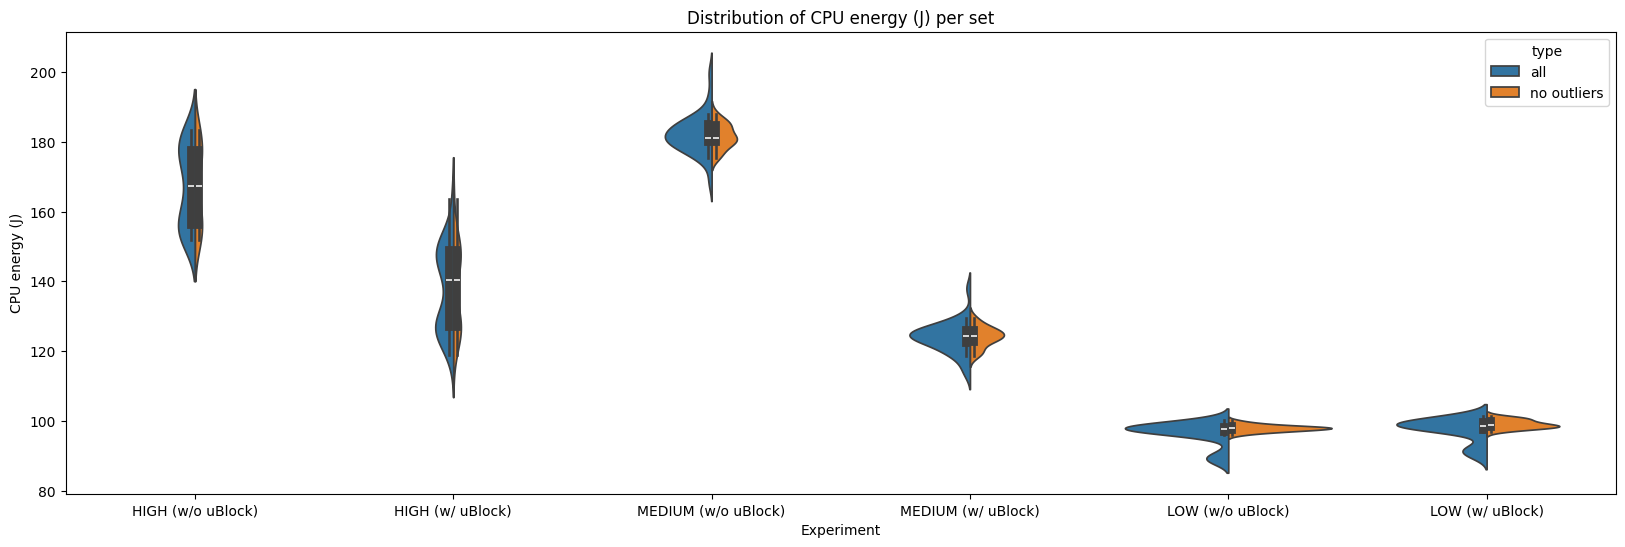

In [8]:
combined_df = pd.concat([df_all, df_set])

sns.violinplot(x='experiment_label', y='total_energy', hue='type', data=combined_df, split=True)
plt.xlabel('Experiment')
plt.ylabel('CPU energy (J)')
plt.gcf().set_size_inches(20, 6)
plt.title(f'Distribution of CPU energy (J) per set')
plt.show()

In [9]:
data = []
for set_value in range(3):
	for experiment_value in range(2):
		filtered_df = df[(df['set'] == str(set_value)) & (df['experiment'] == str(experiment_value))]
		
		for site in ['site_1', 'site_2', 'site_3']:
			q1 = filtered_df[site].quantile(0.25)
			q3 = filtered_df[site].quantile(0.75)
			iqr = q3 - q1
			lower_bound = q1 - 1.5 * iqr
			upper_bound = q3 + 1.5 * iqr
			filtered_df_no = filtered_df[(filtered_df[site] >= lower_bound) & (filtered_df[site] <= upper_bound)]
			
			for value in filtered_df_no[site]:
				data.append({
					'experiment': experiment_value,
					'experiment_label': "No uBlock" if experiment_value == 0 else "uBlock",
					'set': set_value,
					'site': int(site.split('_')[1])-1,
					'total_energy': value
				})
df_site = pd.DataFrame(data)


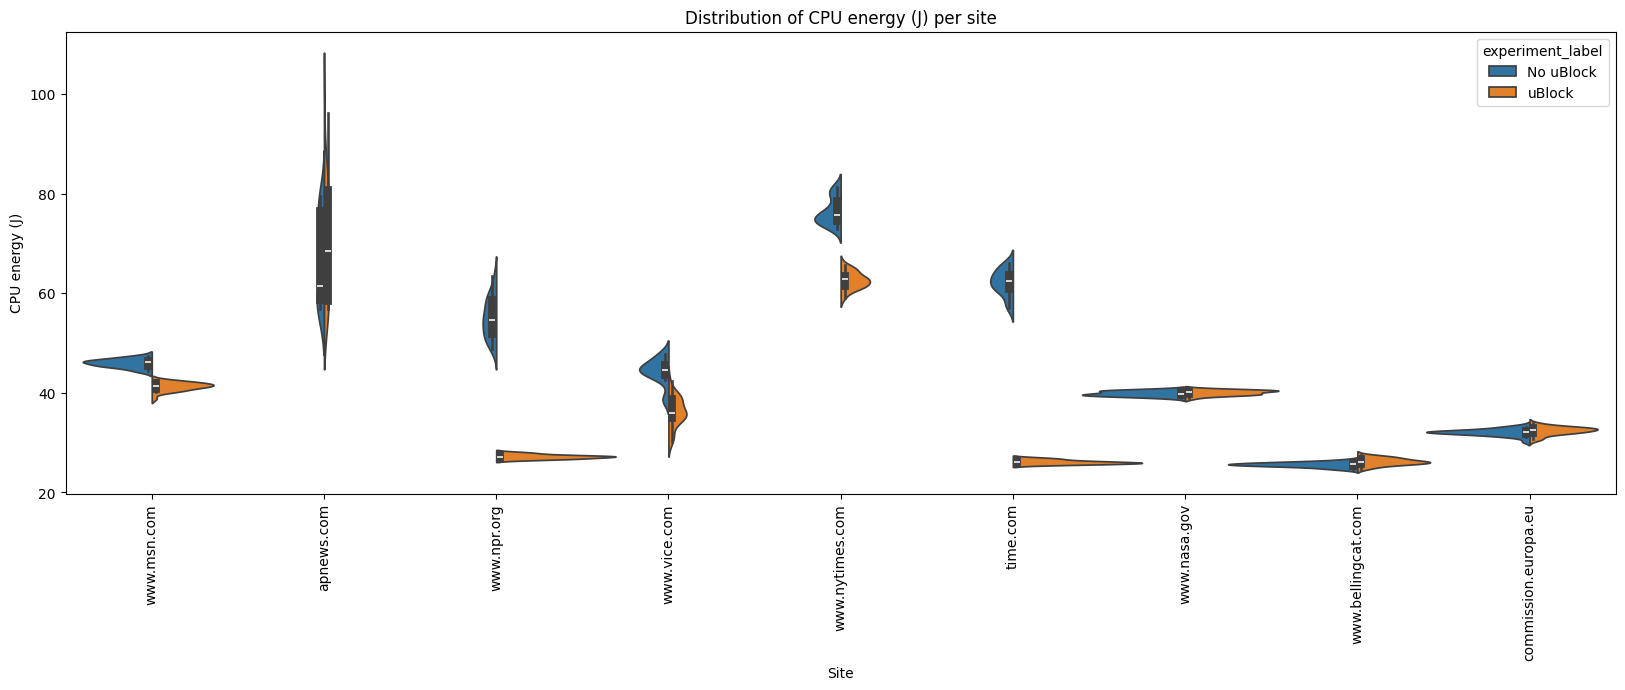

In [10]:
labels = []
for index, row in df_site.iterrows():
	site_label = SITES[list(SITES.keys())[row['set']]][row['site']]
	site_label = site_label.split('/')[2]
	labels.append(site_label)
df_site['label'] = labels
sns.violinplot(x='label', y='total_energy', hue='experiment_label', data=df_site, split=True, gap=0, width=1.5)
plt.xticks(rotation=90)
plt.xlabel('Site')
plt.ylabel('CPU energy (J)')
plt.gcf().set_size_inches(20, 6)
plt.title(f'Distribution of CPU energy (J) per site')
plt.show()

In [169]:
data = []
data2 = []
for set_value in range(3):
	exp_data = []
	for experiment_value in range(2):
		filtered_df = df_set[(df_set['set'] == set_value) & (df_set['experiment'] == experiment_value)]

		stat, p = normaltest(filtered_df['total_energy'])
		exp_data.append({
			'experiment': experiment_value,
			'mean': filtered_df['total_energy'].mean(),
			'std_dev': filtered_df['total_energy'].std(),
			'p': p,
			'data': filtered_df['total_energy']
		})

	if exp_data[0]['p'] >= 0.05 and exp_data[1]['p'] >= 0.05:
		welch = ttest_ind(exp_data[0]['data'], exp_data[1]['data'], equal_var=False, alternative='two-sided').pvalue
		mwu = "N/A"
	else:
		welch = "N/A"
		mwu = mannwhitneyu(exp_data[0]['data'], exp_data[1]['data'], alternative='two-sided').pvalue

	data.append({
		'Set': list(SITES.keys())[set_value],
		'Mean (No uBlock)': round(exp_data[0]['mean'], 3),
		'Mean (With uBlock)': round(exp_data[1]['mean'], 3),
		'Std Dev (No uBlock)': round(exp_data[0]['std_dev'], 3),
		'Std Dev (With uBlock)': round(exp_data[1]['std_dev'], 3),
		'Shapiro-Wilk (No uBlock)': round(exp_data[0]['p'], 3),
		'Shapiro-Wilk (With uBlock)': round(exp_data[1]['p'], 3),
		't-test (p)': ("<0.001" if welch < 0.001 else round(welch, 3)) if welch != "N/A" else welch,
		'U-test (p)': ("<0.001" if mwu < 0.001 else round(mwu, 3)) if mwu != "N/A" else mwu
	})

	data2.append({
		'Set': list(SITES.keys())[set_value],
		'Mean diff (ΔX)': round(exp_data[1]['mean'] - exp_data[0]['mean'], 3),
		'Mean change (%)': str(round((exp_data[1]['mean'] - exp_data[0]['mean']) / exp_data[0]['mean'] * 100, 3)) + "%",
		'Effect size (Cohen\'s d)': "N/A" if welch == "N/A" else round((exp_data[1]['mean'] - exp_data[0]['mean']) / numpy.sqrt((exp_data[0]['std_dev'] ** 2 + exp_data[1]['std_dev'] ** 2) / 2), 3)
	})

results_per_set = pd.DataFrame(data)
markdown_table_per_set = results_per_set.to_markdown(index=False)
print(markdown_table_per_set)
print()
results_per_set = pd.DataFrame(data2)
markdown_table_per_set = results_per_set.to_markdown(index=False, colalign=("left", "right", "right", "right"))
print(markdown_table_per_set)

| Set    |   Mean (No uBlock) |   Mean (With uBlock) |   Std Dev (No uBlock) |   Std Dev (With uBlock) |   Shapiro-Wilk (No uBlock) |   Shapiro-Wilk (With uBlock) | t-test (p)   | U-test (p)   |
|:-------|-------------------:|---------------------:|----------------------:|------------------------:|---------------------------:|-----------------------------:|:-------------|:-------------|
| HIGH   |            167.109 |              137.896 |                11.508 |                  11.865 |                      0     |                        0.026 | N/A          | <0.001       |
| MEDIUM |            181.628 |              124.173 |                 3.465 |                   2.871 |                      0.622 |                        0.826 | <0.001       | N/A          |
| LOW    |             97.948 |               99.112 |                 0.95  |                   1.243 |                      0.796 |                        0.419 | <0.001       | N/A          |

| Set    |   Mean diff (

In [174]:
from scipy.stats import ttest_ind, mannwhitneyu

data = []
data2 = []
for set_value in range(3):
	for site in range(3):
		exp_data = []
		for experiment_value in range(2):
			filtered_df = df_site[(df_site['set'] == set_value) & (df_site['site'] == site) & (df_site['experiment'] == experiment_value)]
			
			stat, p = normaltest(filtered_df['total_energy'])
			exp_data.append({
				'experiment': experiment_value,
				'mean': filtered_df['total_energy'].mean(),
				'std_dev': filtered_df['total_energy'].std(),
				'p': p,
				'data': filtered_df['total_energy']
			})
		url = SITES[list(SITES.keys())[set_value]][site]
		domain = url.split('/')[2]

		if exp_data[0]['p'] >= 0.05 and exp_data[1]['p'] >= 0.05:
			welch = ttest_ind(exp_data[0]['data'], exp_data[1]['data'], equal_var=False, alternative='two-sided').pvalue
			mwu = "N/A"
		else:
			welch = "N/A"
			mwu = mannwhitneyu(exp_data[0]['data'], exp_data[1]['data'], alternative='two-sided').pvalue

		data.append({
			'Domain': domain,
			'Mean (No uBlock)': round(exp_data[0]['mean'], 3),
			'Mean (With uBlock)': round(exp_data[1]['mean'], 3),
			'Std dev (No uBlock)': round(exp_data[0]['std_dev'], 3),
			'Std dev (With uBlock)': round(exp_data[1]['std_dev'], 3),
			'Shapiro-Wilk (No uBlock)': round(exp_data[0]['p'], 3),
			'Shapiro-Wilk (With uBlock)': round(exp_data[1]['p'], 3),
			't-test (p)': ("<0.001" if welch < 0.001 else round(welch, 3)) if welch != "N/A" else welch,
			'U-test (p)': ("<0.001" if mwu < 0.001 else round(mwu, 3)) if mwu != "N/A" else mwu
		})

		data2.append({
			'Domain': domain,
			'Mean diff (ΔX)': round(exp_data[1]['mean'] - exp_data[0]['mean'], 3),
			'Mean change (%)': str(round((exp_data[1]['mean'] - exp_data[0]['mean']) / exp_data[0]['mean'] * 100, 3)) + "%",
			'Effect size (Cohen\'s d)': "N/A" if welch == "N/A" else round((exp_data[1]['mean'] - exp_data[0]['mean']) / numpy.sqrt((exp_data[0]['std_dev'] ** 2 + exp_data[1]['std_dev'] ** 2) / 2), 3)
		})

results = pd.DataFrame(data)
markdown_table = results.to_markdown(index=False)
print(markdown_table)
print()
results = pd.DataFrame(data2)
markdown_table = results.to_markdown(index=False)
print(markdown_table)


| Domain               |   Mean (No uBlock) |   Mean (With uBlock) |   Std dev (No uBlock) |   Std dev (With uBlock) |   Shapiro-Wilk (No uBlock) |   Shapiro-Wilk (With uBlock) | t-test (p)   | U-test (p)   |
|:---------------------|-------------------:|---------------------:|----------------------:|------------------------:|---------------------------:|-----------------------------:|:-------------|:-------------|
| www.msn.com          |             45.958 |               41.294 |                 0.835 |                   0.853 |                      0.758 |                        0.061 | <0.001       | N/A          |
| apnews.com           |             66.957 |               69.932 |                 9.102 |                  11.969 |                      0     |                        0.003 | N/A          | 0.149        |
| www.npr.org          |             55.04  |               27.226 |                 3.936 |                   0.425 |                      0.474 |                 